<a href="https://colab.research.google.com/github/Chygos/Zindi/blob/main/Runmila%20Tuberculosis%20clasification/Runmila_TB_Classification(Baseline).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive, files

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
path = "drive/My Drive/Zindi/TB XRay Challenge/"

In [ ]:
import os,gc, warnings
warnings.filterwarnings('ignore')

In [ ]:
os.listdir(path)

['Train.csv',
 'test_small.zip',
 'Test.csv',
 'SampleSubmission.csv',
 'train_small.zip',
 'test_small',
 'train_small']

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split, StratifiedKFold
import seaborn as sns
import cv2
from functools import partial

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, optimizers, Sequential
import tensorflow.keras as tf_keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Flatten, BatchNormalization, Conv2D
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.applications.vgg16 import preprocess_input

In [ ]:
#for reproducibility
SEED = 123
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
# !unzip '/content/drive/My Drive/Zindi/TB XRay Challenge/train_small.zip' -d '/content/drive/My Drive/Zindi/TB XRay Challenge'
# !unzip '/content/drive/My Drive/Zindi/TB XRay Challenge/test_small.zip' -d '/content/drive/My Drive/Zindi/TB XRay Challenge'

In [ ]:
train = pd.read_csv(path+'Train.csv')
test = pd.read_csv(path+'Test.csv')
subfile = pd.read_csv(path+'SampleSubmission.csv')
train_path = path+'train_small/'
test_path = path+'test_small/'

In [ ]:
train.shape,test.shape

((718, 3), (82, 2))

In [ ]:
train.head(2)

,filename,ID,LABEL
0,train/VTYNBFTO.png,VTYNBFTO,1
1,train/GVVXXDOZ.png,GVVXXDOZ,0


In [ ]:
test.head(2)

,filename,ID
0,test/GTWSHFYQ.png,GTWSHFYQ
1,test/QTFSSMGD.png,QTFSSMGD


In [ ]:
subfile.head(2)

,ID,LABEL
0,GTWSHFYQ,0
1,QTFSSMGD,0


In [ ]:
train_ids = train.ID.values
test_ids = test.ID.values
train_labels = train.LABEL

In [ ]:
train_images = pd.DataFrame({'filepath' : train_path+train_ids+'.png', 'ID' : train_ids, 'LABEL' : train_labels})
test_images = pd.DataFrame({'filepath' : test_path+test_ids+'.png', 'ID' : test_ids})

In [ ]:
train_images.shape, test_images.shape

((718, 3), (82, 2))

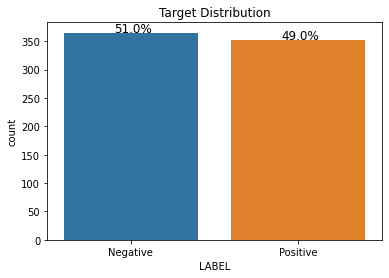

In [ ]:
ax = sns.countplot(train_images.LABEL)
plt.xticks(range(2), ['Negative', 'Positive'])
for i in ax.patches:
  plt.text(i.get_x()+0.3, i.get_height()+0.2, str(np.round(i.get_height()/len(train),2)*100)+'%',
           fontsize=12, fontweight=60)
plt.title('Target Distribution');

The Target Distribution is somewhat Balanced

In [ ]:
train_images.head(2)

,filepath,ID,LABEL
0,drive/My Drive/Zindi/TB XRay Challenge/train_s...,VTYNBFTO,1
1,drive/My Drive/Zindi/TB XRay Challenge/train_s...,GVVXXDOZ,0


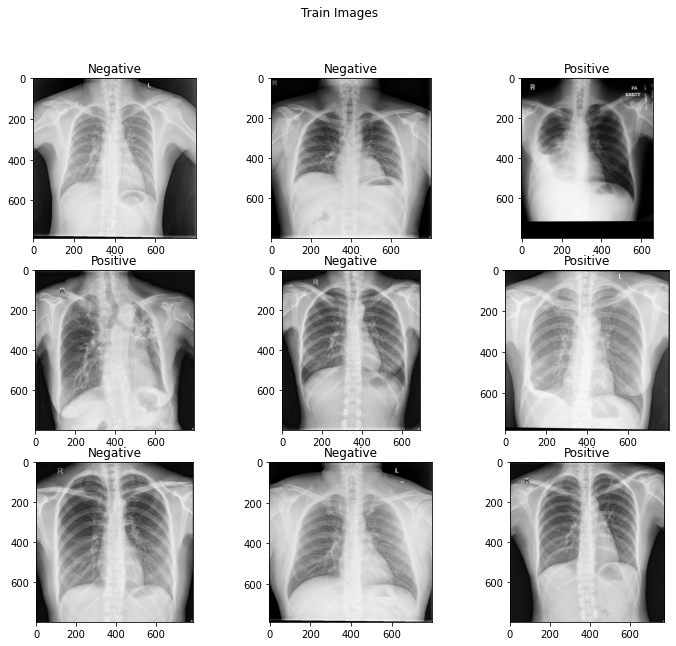

In [ ]:
plt.figure(figsize=(12,10))
for i in range(9):
  img_data = train_images.sample(1)
  img = cv2.imread(img_data.iloc[0].filepath)
  plt.subplot(3,3, i+1)
  plt.imshow(img)
  label_map = {0:'Negative', 1:'Positive'}
  plt.title(label_map.get(img_data.LABEL.iloc[0], None))
plt.suptitle('Train Images');

In [ ]:
#splitting data into train and validatio sets
train_data, valid_data= train_test_split(train_images, random_state=SEED, test_size=0.2, stratify=train_images.LABEL)

In [ ]:
train_data.shape, valid_data.shape

((574, 3), (144, 3))

In [ ]:
print(train_data.LABEL.value_counts())
print(valid_data.LABEL.value_counts())

0    292
1    282
Name: LABEL, dtype: int64
0    73
1    71
Name: LABEL, dtype: int64


In [ ]:
train_data.LABEL = train_data.LABEL.map({0:'Negative', 1:'Positive'}) #converting label to string for image data generator requirement
valid_data.LABEL = valid_data.LABEL.map({0:'Negative', 1:'Positive'})

In [ ]:
#Data generators and data augmentation of train set
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True,zoom_range=0.2, rotation_range=40,
                                   width_shift_range=0.2, height_shift_range=0.2, channel_shift_range=10., shear_range=10, fill_mode='nearest',)
valid_datagen = ImageDataGenerator(rescale=1./255) #dont perform data augmentation on both validation and test sets

In [ ]:
image_size= (224,224)
batch_size = 32
train_steps = len(train_data) // batch_size
valid_steps = len(valid_data) // batch_size

classes = train_data.LABEL.unique().tolist()

In [ ]:
train_gen= train_datagen.flow_from_dataframe(train_data, x_col = 'filepath', y_col='LABEL', target_size=image_size, classes=classes,
                                             class_mode='categorical', seed=SEED, batch_size=batch_size, shuffle=True)

val_gen = valid_datagen.flow_from_dataframe(valid_data, x_col='filepath', y_col='LABEL', target_size=image_size, class_mode='categorical',
                                            classes=classes, shuffle=False, batch_size=batch_size, seed=SEED)#dont shuffle val or test data

test_gen = valid_datagen.flow_from_dataframe(test_images, class_mode=None, x_col = 'filepath', target_size=image_size, shuffle=False, 
                                             batch_size=batch_size)

Found 574 validated image filenames belonging to 2 classes.
Found 144 validated image filenames belonging to 2 classes.
Found 82 validated image filenames.


**Model Building**

**`Without Pretrained Models`**

In [ ]:
input_shape= (224, 224, 3) #height, width, channels

In [ ]:
Default_conv2d = partial(Conv2D, kernel_size=3, padding='VALID', activation='relu')

In [ ]:
def modelBuild(input_shape):
  model = Sequential(name='conv2d')
  model.add(Default_conv2d(filters=32, kernel_size=3, input_shape=input_shape))
  model.add(layers.MaxPool2D(pool_size=2))
  model.add(Default_conv2d(filters=64))
  model.add(layers.MaxPool2D(pool_size=2))
  model.add(Default_conv2d(filters=128))
  model.add(Default_conv2d(filters=128))
  model.add(layers.MaxPool2D(pool_size=2))
  model.add(Default_conv2d(filters=256))
  model.add(layers.MaxPool2D(pool_size=2))
  model.add(Default_conv2d(filters=256))
  model.add(layers.MaxPool2D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.3))
  # model.add(GlobalAveragePooling2D())
  model.add(Dense(2, activation='softmax')) #because probailities are needed
  model.summary()
  return model

In [ ]:
model = modelBuild(input_shape=input_shape)

Model: "conv2d"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 50, 50, 128)       147584    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 25, 25, 128)       0    

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-4), metrics=['AUC'])

In [ ]:
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
checkpoint_path = os.path.join(path, 'No_pretrained_model.h5')
modelcheck = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', mode='auto', save_best_only=True, verbose=1)

In [ ]:
gc.collect()

4

In [ ]:
history = model.fit(train_gen, epochs=100, steps_per_epoch=train_steps, shuffle=True, validation_steps=valid_steps,
                    validation_data=(val_gen), callbacks=[es, modelcheck]);

Epoch 1/100
17/17 [==============================] - ETA: 0s - loss: 0.6957 - auc: 0.4913
Epoch 00001: val_loss improved from inf to 0.69363, saving model to drive/My Drive/Zindi/TB XRay Challenge/No_pretrained_model.h5
17/17 [==============================] - 13s 773ms/step - loss: 0.6957 - auc: 0.4913 - val_loss: 0.6936 - val_auc: 0.5361
Epoch 2/100
17/17 [==============================] - ETA: 0s - loss: 0.6959 - auc: 0.5063
Epoch 00002: val_loss improved from 0.69363 to 0.69268, saving model to drive/My Drive/Zindi/TB XRay Challenge/No_pretrained_model.h5
17/17 [==============================] - 13s 749ms/step - loss: 0.6959 - auc: 0.5063 - val_loss: 0.6927 - val_auc: 0.5645
Epoch 3/100
17/17 [==============================] - ETA: 0s - loss: 0.6942 - auc: 0.5055
Epoch 00003: val_loss did not improve from 0.69268
17/17 [==============================] - 12s 713ms/step - loss: 0.6942 - auc: 0.5055 - val_loss: 0.6934 - val_auc: 0.4924
Epoch 4/100
17/17 [==============================

In [ ]:
history.history.keys()

dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])

In [ ]:
tr_auc = history.history['auc']
val_auc = history.history['val_auc']
tr_loss = history.history['loss']
val_loss = history.history['val_loss']

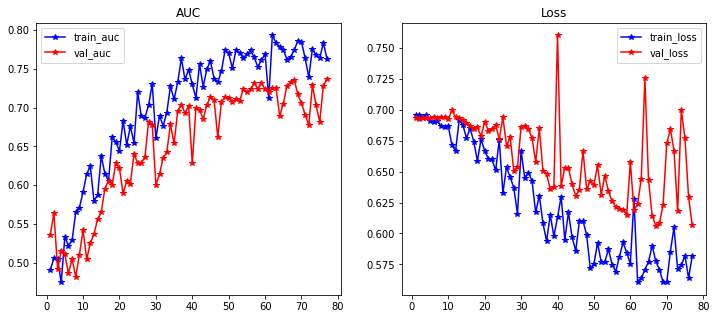

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(range(1, len(tr_auc)+1), tr_auc, 'b-*', label='train_auc')
plt.plot(range(1, len(tr_auc)+1), val_auc, 'r-*', label='val_auc')
plt.title('AUC')
plt.legend()

plt.subplot(122)
plt.plot(range(1, len(tr_auc)+1), tr_loss, 'b-*', label='train_loss')
plt.plot(range(1, len(tr_auc)+1), val_loss, 'r-*', label='val_loss')
plt.title('Loss')
plt.legend();

In [ ]:
y_preds = model.predict_proba(val_gen)[:,1]

In [ ]:
auc_score = roc_auc_score(val_gen.classes, y_preds)

In [ ]:
fpr, tpr, thresholds = roc_curve(val_gen.classes, y_preds)

In [ ]:
auc(fpr, tpr)

0.7204321821338993

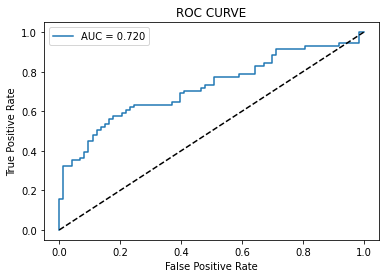

In [ ]:
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc_score))
plt.plot([0,1], [0,1], 'k--')
plt.title('ROC CURVE')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend();

**Submission**

In [ ]:
test_preds = model.predict_proba(test_gen)[:, 1]

In [ ]:
submission = pd.DataFrame({'ID': test_ids, 'LABEL':test_preds})

In [ ]:
submission.head()

,ID,LABEL
0,GTWSHFYQ,0.199524
1,QTFSSMGD,0.328829
2,TBLBHSYT,0.397390
3,ZKETEOFG,0.428835
4,GKTPBGZP,0.459392


In [ ]:
submission.to_csv(os.path.join(path, 'no_pretrained_model.csv'), index=False)

In [ ]:
files.download(path+'no_pretrained_model.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**LB Score = 0.801**<br>
**Final LB= ~0.781**

In [ ]:
gc.collect()

291